In [64]:
# python libraries
import autograd.numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

plt.style.use('seaborn') 

In [65]:
from autograd import elementwise_grad as egrad
from autograd import jacobian,hessian

In [67]:
import itertools
import torch

In [68]:
# !pip install ffmpeg

In [69]:
from matplotlib.animation import FuncAnimation

In [70]:
from matplotlib import rc

# equivalent to rcParams['animation.html'] = 'html5'
rc('animation', html='html5')

In [71]:
plt.rcParams.update({'font.family':'Times New Roman'})
plt.rcParams['font.size'] = 13

### Define vehicle dynamics:


In [72]:
n_x = 4
n_u = 2
def unicycle_continuous_dynamics(x, u):
    # x = [x position, y position, heading, forward velocity] 
    # u = [omega, forward acceleration]
    #m = sym if x.dtype == object else np # Check type for autodiff
    x_pos = x[3]*np.cos(x[2])
    y_pos = x[3]*np.sin(x[2])
    heading_rate = u[0]
    v_dot = u[1]
    x_d = np.array([
        x_pos,
        y_pos,
        heading_rate,
        v_dot    
    ])
    return x_d

In [73]:
def discrete_dynamics(x, u):
    dt = 0.05
    #Euler integrator below and return the next state
    x = x + dt*unicycle_continuous_dynamics(x,u)
    x_next = x
    return x_next

In [74]:
def discrete_dynamics_multiple(x,u,x_dim,u_dim):
        
    x_new = np.hstack(
         [discrete_dynamics(x[i*n_states:(i+1)*n_states],u[i*n_inputs:(i+1)*n_inputs]) for i in range(len(x_dim))]
    )

    return x_new

### Rollout 


In [75]:
def rollout(x0, u_trj, x_dim, u_dim): #rolling out the state trajectory based on the euqations of motion (discretized)

    x_trj = np.zeros((u_trj.shape[0]+1, x0.shape[0]))

    x_trj[0,:] = x0
    
    for i in range(0,x_trj.shape[0]-1): 
        x_trj[i+1,:] = discrete_dynamics_multiple(x_trj[i,:],u_trj[i,:],x_dim,u_dim)
    
    return x_trj

### Define cost functions:

In [76]:
def cost_trj(x,u,x_ref): #x-> state vector, u-> input vector
    
    
    Q = np.zeros((len(x),len(x)))
    
    for i,j in zip(range(n_agents),range(n_agents)): 
      #n_agents,n_states are global variables to be declared before the main iLQR loop
      
      Q[i*n_states:(i+1)*n_states,j*n_states:(j+1)*n_states] = np.diag([200,200,0,0,])  
      
      #we don't want to penalize the 3rd and 4th state in each agent (heading&velocity)
    
    R = np.eye(u.shape[0])
    
    cost = (x-x_ref).T @ Q @(x-x_ref) +(u).T @ R @ (u)

    return cost #trajectory cost for an agent with index i

In [77]:
def cost_trj_Final(x_T,x_ref_T):
   # m = sym if x.dtype == object else np
    Q = np.eye(x_T.shape[0])*1600
    
    terminal_cost = (x_T-x_ref_T).T @ Q @ (x_T-x_ref_T)

    return terminal_cost #final trajectory cost for an agent with index i

In [78]:
def compute_pairwise_distance(X, x_dims):
    """Compute the distance between each pair of agents"""
    assert len(set(x_dims)) == 1

    n_agents = len(x_dims)
    n_states = x_dims[0]
    
    pair_inds = np.array(list(itertools.combinations(range(n_agents), 2)))
    X_agent = X.reshape(-1, n_agents, n_states).swapaxes(0, 2)
    dX = X_agent[:2, pair_inds[:, 0]] - X_agent[:2, pair_inds[:, 1]]

    # if torch.is_tensor(X):
    #     return torch.linalg.norm(dX, dim=0)
    
    return np.linalg.norm(dX, axis=0)

In [79]:
def cost_avoidance(x,x_dim):
    
    if len(x_dim) == 1:
        
        return 0
    
    threshold = 0.5 #threshold distance below which cost avoidance is activated

    distances = compute_pairwise_distance(x,x_dim)

    cost_avoid = np.sum((distances[distances<threshold]-threshold)**2)*1000
    return cost_avoid

In [80]:
def cost_stage(x, u, x_dim, x_ref):
    
    c_avoid = cost_avoidance(x,x_dim)
    c_trj = cost_trj(x,u,x_ref)
    
    return c_avoid + c_trj

In [81]:
def cost_sum(x_trj, u_trj, x_dim, x_ref, x_ref_T):

    total = 0.0
    # TODO: Sum up all costs
    for i in range(0,x_trj.shape[0]-1): #(0,1,2,3,....)
        total = total + cost_stage(x_trj[i,:], u_trj[i,:], x_dim, x_ref) 

    total = total + cost_trj_Final(x_trj[-1,:], x_ref_T)

    return total

### Bellman recursion (ref:http://underactuated.mit.edu/trajopt.html#section8)


Now that we are warmed up, let's derive the actual algorithm. We start with the Bellman equation known from lecture defining optimality in a recursively backwards in time.
\begin{align*} V(\mathbf{x}[n]) = & \min_{\mathbf{u}[n]} \quad \ell(\mathbf{x}[n], \mathbf{u}[n])  + V(\mathbf{x}[n+1]) \\
\end{align*}

You may have noticed that we neglected a couple of constraints of the original problem formulation. The fully equivalent formulation is 
\begin{align*} \min_{\mathbf{u}[n]} \quad & Q(\mathbf{x}[n], \mathbf{u}[n]), \quad \forall n\in[0, N-1]
\\ \text{subject to} \quad 
& Q(\mathbf{x}[n], \mathbf{u}[n]) = \ell(\mathbf{x}[n], \mathbf{u}[n])  + V(\mathbf{x}[n+1]) \\
& V(\mathbf{x}[N]) =   \ell_f(\mathbf{x}[N]) \\
& \mathbf{x}[n+1] = {\bf      f}(\mathbf{x}[n], \mathbf{u}[n]), \quad \\ 
& \mathbf{x}[0] = \mathbf{x}_0.
\end{align*}
The definition of a Q-function will become handy during the derivation of the algorithm.

The key idea of iLQR is simple: Approximate the dynamics linearly and the costs quadratically around a nominal trajectory. We will expand all terms of the Q-function accordingly and optimize the resulting quadratic equation for an optimal linear control law in closed form. We will see that by applying the Bellman equation recursively backwards in time, the value function remains a quadratic.
The linear and quadratic approximations are computed around the nominal state $\bf \bar{x} = \bf x - \delta \bf x$ and the nominal control $\bf \bar{u} = \bf u - \delta \bf u$. After applying the Bellman equation backwards in time from time $N$ to $0$ (the backward pass), we will update the nominal controls $\bf \bar{u}$ and states $\bf \bar{x}$ by applying the computed linear feedback law from the backward pass and rolling out the dynamics from the initial state $\bf x_0$ to the final horizon $N$. Iterating between backwards and forwards pass optimizes the control problem.

### Q-function Expansion

Let's start by expanding all terms in the Q-function of the Bellman equation. The quadaratic cost function is
\begin{align*} 
\ell(\mathbf{x}[n], \mathbf{u}[n]) \approx \ell_n 
+ \begin{bmatrix}\ell_{\mathbf{x},n} \\  \ell_{\mathbf{u},n} \end{bmatrix} ^T  \begin{bmatrix} \delta \mathbf{x}[n] \\ \delta \mathbf{u}[n] \end{bmatrix}
+ \frac{1}{2}\begin{bmatrix} \delta \mathbf{x}[n] \\ \delta \mathbf{u}[n] \end{bmatrix} ^T 
\begin{bmatrix}\ell_{\mathbf{xx},n} &  \ell_{\mathbf{ux},n}^T\\  
\ell_{\mathbf{ux},n} & \ell_{\mathbf{uu},n}\end{bmatrix}
 \begin{bmatrix} \delta \mathbf{x}[n] \\ \delta \mathbf{u}[n] \end{bmatrix},
\end{align*}
and the dynamics function is
\begin{align*} x[n+1]=
\mathbf{f}(\mathbf{x}[n], \mathbf{u}[n]) \approx \mathbf{f}_n
+ \begin{bmatrix}\mathbf{f}_{\mathbf{x},n} & \mathbf{f}_{\mathbf{u},n} \end{bmatrix}  \begin{bmatrix} \delta \mathbf{x}[n] \\ \delta \mathbf{u}[n] \end{bmatrix}.
\end{align*}
Here, $\ell = \ell(\bar{\mathbf{x}}, \bar{\mathbf{u}})$ and $\mathbf{f} = \mathbf{f}(\bar{\mathbf{x}}, \bar{\mathbf{u}})$. $\ell_\mathbf{x}, \ell_\mathbf{u}, \mathbf{f}_\mathbf{x}, \mathbf{f}_\mathbf{u}$ are the gradients and Jacobians evaluated at $\bar{\mathbf{x}}$ and $\bar{\mathbf{u}}$. $\ell_\mathbf{xx}, \ell_\mathbf{ux}, \ell_\mathbf{uu}$ are the Hessians at $\bar{\mathbf{x}}$ and $\bar{\mathbf{u}}$. The expansion of the final cost follows analogously.
The code to evaluate all the derivative terms is:

In [82]:
from scipy.optimize import approx_fprime

### Defining derivatives of cost_stage(x,u) : `l_x, l_u, l_xx, l_ux, l_uu`

In [83]:
from autograd import elementwise_grad as egrad

In [95]:

def l_x(x,u,x_dim,x_ref):
  
    return egrad(cost_stage,0)(x,u,x_dim,x_ref)
    # return approx_fprime(x, lambda x: cost_stage(x, u, x_dim, x_ref), jac_eps)
    
def l_u(x,u,x_dim,x_ref):
    
    return egrad(cost_stage,1)(x,u,x_dim,x_ref)
    # return approx_fprime(u, lambda u: cost_stage(x, u, x_dim, x_ref), jac_eps)
    
def l_xx(x,u,x_dim,x_ref):
    
    return hessian(cost_stage,0)(x,u,x_dim,x_ref)
    # return np.vstack(
    #      [approx_fprime(x, lambda x: l_x(x,u,x_dim,x_ref)[i], hess_eps) for i in range(len(x))]
    # )
    
def l_uu(x,u,x_dim,x_ref):
    
    return hessian(cost_stage,1)(x,u,x_dim,x_ref)
    # return  np.vstack(
    #      [approx_fprime(u, lambda u: l_u(x,u,x_dim,x_ref)[i], hess_eps) for i in range(len(u))]
    #  )
    

def l_ux(x,u,x_dim,x_ref): #this is not correct?
    
    return jacobian(l_u,0)(x,u,x_dim,x_ref)#, somehow auto-differentiation throws warning on l_ux all the time
    
    # return  np.vstack(
    #     [approx_fprime(x, lambda x: l_u(x,u,x_dim,x_ref)[i], hess_eps) for i in range(len(u))]
    # )

#note: warning shows up later due to the fact that l_ux( ) is always a zero array, but that's okay
 

In [97]:

def f(x,u,x_dim,u_dim):
    
    return discrete_dynamics_multiple(x,u,x_dim,u_dim)

def f_x(x,u,x_dim,u_dim):
    
    return jacobian(f,0)(x,u,x_dim,u_dim)
    # return np.vstack([approx_fprime(x, lambda x: f(x,u,x_dim,u_dim)[i], jac_eps) for i in range(len(x))])

def f_u(x,u,x_dim,u_dim): #this is not correct
    
    
    return jacobian(f,1)(x,u,x_dim,u_dim)
    # return np.vstack([approx_fprime(u, lambda u: f(x,u,x_dim,u_dim)[i], jac_eps) for i in range(len(x))])




In [98]:
def l_final_x(x_T,x_ref_T):
    
    
    return np.eye(x_T.shape[0])*1500@(x_T-x_ref_T)


def l_final_xx(x_T):
    

    return np.eye(x_T.shape[0])*1500


Expanding the second term of the Q-function of the Bellman equation, i.e. the value function at the next state $\mathbf{x}[n+1]$, to second order yields \begin{align*} 
V(\mathbf{x}[n+1]) \approx V_{n+1} + 
V_{\mathbf{x},n+1}^T  \delta \mathbf{x}[n+1] + \frac{1}{2}\delta \mathbf{x}[n+1]^T 
V_{\mathbf{xx},n+1} \delta \mathbf{x}[n+1],
\end{align*}
where $\delta \mathbf{x}[n+1]$ is given by
\begin{align*} 
\delta \mathbf{x}[n+1] 
& = \mathbf{x}[n+1] - \bar{\mathbf{x}}[n+1] \\
& = \mathbf{f}_n + \begin{bmatrix}\mathbf{f}_{\mathbf{x},n} &  \mathbf{f}_{\mathbf{u},n} \end{bmatrix}  \begin{bmatrix} \delta \mathbf{x}[n] \\ \delta \mathbf{u}[n] \end{bmatrix} -  \bar{\mathbf{x}}[n+1] \\
& = \mathbf{f}_n + \begin{bmatrix}\mathbf{f}_{\mathbf{x},n} & \mathbf{f}_{\mathbf{u},n} \end{bmatrix}  \begin{bmatrix} \delta \mathbf{x}[n] \\ \delta \mathbf{u}[n] \end{bmatrix} -  \mathbf{f}(\bar{\mathbf{x}}[n], \bar{\mathbf{u}}[n]) \\
& = \begin{bmatrix}\mathbf{f}_{\mathbf{x},n} &  \mathbf{f}_{\mathbf{u},n} \end{bmatrix}   \begin{bmatrix} \delta \mathbf{x}[n] \\ \delta \mathbf{u}[n] \end{bmatrix}.
\end{align*}

We have now expanded all terms of the Bellman equation and can regroup them in the form of
\begin{align*} 
Q(\mathbf{x}[n], \mathbf{u}[n]) & 
\approx \ell_n 
+ \begin{bmatrix}\ell_{\mathbf{x},n} \\  \ell_{\mathbf{u},n} \end{bmatrix} ^T  \begin{bmatrix} \delta \mathbf{x}[n] \\ \delta \mathbf{u}[n] \end{bmatrix}
+ \frac{1}{2}\begin{bmatrix} \delta \mathbf{x}[n] \\ \delta \mathbf{u}[n] \end{bmatrix} ^T 
\begin{bmatrix}\ell_{\mathbf{xx},n} &  \ell_{\mathbf{ux},n}^T\\  
\ell_{\mathbf{ux},n} & \ell_{\mathbf{uu},n}\end{bmatrix}
 \begin{bmatrix} \delta \mathbf{x}[n] \\ \delta \mathbf{u}[n] \end{bmatrix}, \\
 & \quad + V_{n+1} + 
V_{\mathbf{x},n+1}^T  \delta \mathbf{x}[n+1] + \frac{1}{2}\delta \mathbf{x}[n+1]^T 
V_{\mathbf{xx},n+1} \delta \mathbf{x}[n+1], \\
& = Q_n 
+ \begin{bmatrix} Q_{\mathbf{x},n} \\  Q_{\mathbf{u},n} \end{bmatrix} ^T  \begin{bmatrix} \delta \mathbf{x}[n] \\ \delta \mathbf{u}[n] \end{bmatrix}
+ \frac{1}{2}\begin{bmatrix} \delta \mathbf{x}[n] \\ \delta \mathbf{u}[n] \end{bmatrix} ^T 
\begin{bmatrix} Q_{\mathbf{xx},n} &  Q_{\mathbf{ux},n}^T\\  
Q_{\mathbf{ux},n} & Q_{\mathbf{uu},n}\end{bmatrix}
 \begin{bmatrix} \delta \mathbf{x}[n] \\ \delta \mathbf{u}[n] \end{bmatrix}.
\end{align*}
Find $Q_{\mathbf{x},n}$, $Q_{\mathbf{u},n}$, $Q_{\mathbf{xx},n}$, $Q_{\mathbf{ux},n}$, $Q_{\mathbf{uu},n}$ in terms of $\ell$ and $\textbf{f}$ and their expansions by collecitng coefficients in $(\cdot)\delta \mathbf{x}[n]$, $(\cdot)\delta \mathbf{u}[n]$, $1/2 \delta \mathbf{x}[n]^T (\cdot) \delta \mathbf{x}[n]$, and similar. Write your results in the corresponding function below.

In [134]:
def Q_terms(V_x, V_xx , x, u, x_dim, u_dim, x_ref):

    Q_x = l_x(x,u,x_dim,x_ref) + f_x(x,u,x_dim,u_dim).T@(V_x);
    
    Q_u = l_u(x,u,x_dim,x_ref) + f_u(x,u,x_dim,u_dim).T@(V_x);
    
    Q_xx = l_xx(x,u,x_dim,x_ref) + f_x(x,u,x_dim,u_dim).T@(V_xx.dot(f_x(x,u,x_dim,u_dim)))
    
    Q_ux = l_ux(x,u,x_dim,x_ref) + f_u(x,u,x_dim,u_dim).T@(V_xx.dot(f_x(x,u,x_dim,u_dim)))
    Q_uu = l_uu(x,u,x_dim,x_ref) + f_u(x,u,x_dim,u_dim).T@(V_xx.dot(f_u(x,u,x_dim,u_dim)))

    return Q_x, Q_u, Q_xx, Q_ux, Q_uu

### Q-function Optimization and Optimal Linear Control Law
Now that we have the Q-function in quadratic form, we can optimize for the optimal control gains in closed form.
The original formulation, i.e. optimizing over $\mathbf{u}[n]$,
\begin{align*} \min_{\mathbf{u}[n]} \quad & Q(\mathbf{x}[n], \mathbf{u}[n]),
\end{align*} is equivalent to optimzing over $\delta \mathbf{u}[n]$.

\begin{align*} 
\delta \mathbf{u}[n]^* = {\arg\!\min}_{\delta \mathbf{u}[n]} \quad Q_n 
+ \begin{bmatrix} Q_{\mathbf{x},n} \\  Q_{\mathbf{u},n} \end{bmatrix} ^T  \begin{bmatrix} \delta \mathbf{x}[n] \\ \delta \mathbf{u}[n] \end{bmatrix} + \frac{1}{2}\begin{bmatrix} \delta \mathbf{x}[n] \\ \delta \mathbf{u}[n] \end{bmatrix} ^T 
\begin{bmatrix} Q_{\mathbf{xx},n} &  Q_{\mathbf{ux},n}^T\\  
Q_{\mathbf{ux},n} & Q_{\mathbf{uu},n}\end{bmatrix}
 \begin{bmatrix} \delta \mathbf{x}[n] \\ \delta \mathbf{u}[n] \end{bmatrix}
 = k + K \delta \mathbf{x}[n]
\end{align*} It turns out that the optimal control is linear in $\delta \mathbf{x}[n]$.
Solve the quadratic optimization analytically and derive equations for the feedforward gains $k$ and feedback gains $K$. Implement the function below. Hint: You do not need to compute $Q_\mathbf{uu}^{-1}$ by hand.

In [135]:
def gains(Q_uu, Q_u, Q_ux):
   
    k = np.linalg.solve(Q_uu,-Q_u)
    K = np.linalg.solve(Q_uu,-Q_ux)
    
    
    return k, K

### Value Function Backward Update
We are almost done! We need to derive the backwards update equation for the value function. We simply plugin the optimal control $\delta \mathbf{u}[n]^* = k + K \delta \mathbf{x}[n]$ back into the Q-function which yields the value function
\begin{align*} 
V(\mathbf{x}[n]) \approx V_{n} + 
V_{\mathbf{x},n}^T  \delta \mathbf{x}[n] + \frac{1}{2}\delta \mathbf{x}[n]^T 
V_{\mathbf{xx},n} \delta \mathbf{x}[n] = Q_n 
+ \begin{bmatrix} Q_{\mathbf{x},n} \\  Q_{\mathbf{u},n} \end{bmatrix}^T  
\begin{bmatrix} \delta \mathbf{x}[n] \\ \delta \mathbf{u}[n]^* \end{bmatrix} 
+ \frac{1}{2}\begin{bmatrix} \delta \mathbf{x}[n] \\ \delta \mathbf{u}[n]^* \end{bmatrix}^T 
\begin{bmatrix} Q_{\mathbf{xx},n} &  Q_{\mathbf{ux},n}^T\\  
Q_{\mathbf{ux},n} & Q_{\mathbf{uu},n}\end{bmatrix}
 \begin{bmatrix} \delta \mathbf{x}[n] \\ \delta \mathbf{u}[n]^* \end{bmatrix}.
\end{align*}
Compare terms in $(\cdot) \delta \mathbf{x}[n]$ and $ 1/2 \delta \mathbf{x}[n]^T (\cdot)  \delta \mathbf{x}[n]$, find $V_{\mathbf{x},n}$, and $V_{\mathbf{xx},n}$ and implement the corresponding function below.

In [136]:
def V_terms(Q_x, Q_u, Q_xx, Q_ux, Q_uu, K, k):
    
    V_x = Q_x + K.T.dot(Q_uu.dot(k)) + K.T.dot(Q_u) + Q_ux.T.dot(k);
    V_xx = Q_xx  + K.T.dot(Q_uu.dot(K)) + K.T.dot(Q_ux) + Q_ux.T.dot(K) ;
    
    
    
    return V_x, V_xx

### Expected Cost Reduction
We can also estimate by how much we expect to reduce the cost by applying the optimal controls. Simply subtract the previous nominal Q-value ($\delta \mathbf{x}[n] = 0$ and $\delta \mathbf{u}[n]=0$) from the value function.  The result is implemented below and is a useful aid in checking how accurate the quadratic approximation is during convergence of iLQR and adapting stepsize and regularization.

In [137]:
def expected_cost_reduction(Q_u, Q_uu, k, alpha):
    
    return - alpha*Q_u.T.dot(k) - 0.5  * alpha**2 *   k.T.dot(Q_uu.dot(k))

### Forward Pass
We have now have all the ingredients to implement the forward pass and the backward pass of iLQR. In the forward pass, at each timestep the new updated control $\mathbf{u}' =  \bar{\mathbf{u}} + k + K (x' - \bar{\mathbf{x}})$ is applied and the dynamis propagated based on the updated control. The nominal control and state trajectory $\bar{\mathbf{u}}, \bar{\mathbf{x}}$ with which we computed $k$ and $K$ are then updated and we receive a new set of state and control trajectories.

In [138]:
def forward_pass(x_trj, u_trj, k_trj, K_trj, expected_cost_redu, total_cost, alpha, x_dim, u_dim):
    #alpha is the gradient descent rate

  
    x_trj_new = np.zeros(x_trj.shape)
    x_trj_new[0,:] = x_trj[0,:]
    u_trj_new = np.zeros(u_trj.shape)

    for n in range(u_trj.shape[0]):
        
        u_trj_new[n,:] =u_trj[n,:]+ alpha * k_trj[n,:] + K_trj[n,:].dot((x_trj_new[n,:]-x_trj[n,:])); # Apply feedback law
        
        x_trj_new[n+1,:] =discrete_dynamics_multiple(x_trj_new[n,:],u_trj_new[n,:], x_dim, u_dim);
    
   
    
    return x_trj_new, u_trj_new

### Backward Pass
The backward pass starts from the terminal boundary condition $V(\mathbf{x}[N]) =   \ell_f(\mathbf{x}[N])$, such that $V_{\mathbf{x},N} = \ell_{\mathbf{x},f}$ and $V_{\mathbf{xx},N} = \ell_{\mathbf{xx},f}$. In the backwards loop terms for the Q-function at $n$ are computed based on the quadratic value function approximation at $n+1$ and the derivatives and hessians of dynamics and cost functions at $n$. To solve for the gains $k$ and $K$ an inversion of the matrix $Q_\mathbf{uu}$ is necessary. To ensure invertability and to improve conditioning we add a diagonal matrix to $Q_\mathbf{uu}$. This is equivalent to adding a quadratic penalty on the distance of the new control trajectory from the control trajectory of the previous iteration. The result is a smaller stepsize and more conservative convergence properties.

In [139]:
def backward_pass(x_trj, u_trj, regu, alpha, x_dim, u_dim,x_ref_T,x_ref):
    k_trj = np.zeros([u_trj.shape[0], u_trj.shape[1]])
    K_trj = np.zeros([u_trj.shape[0], u_trj.shape[1], x_trj.shape[1]])
    expected_cost_redu = 0

    V_x = l_final_x(x_trj[-1,:],x_ref_T)

    V_xx = l_final_xx(x_trj[-1,:])
    
    for n in range(u_trj.shape[0]-1, -1, -1):
        
        Q_x, Q_u, Q_xx, Q_ux, Q_uu = Q_terms(V_x, V_xx,x_trj[n+1,:],u_trj[n,:],x_dim,u_dim,x_ref)
        
        # We add regularization to ensure that Q_uu is invertible and nicely conditioned
        Q_uu_regu = Q_uu + np.eye(Q_uu.shape[0])*regu
       
        k, K = gains(Q_uu_regu, Q_u, Q_ux)
        
        k_trj[n,:] = k
        K_trj[n,:,:] = K
        
        V_x, V_xx = V_terms(Q_x, Q_u, Q_xx, Q_ux, Q_uu, K, k)
        
        expected_cost_redu += expected_cost_reduction(Q_u, Q_uu, k, alpha)
    return k_trj, K_trj, expected_cost_redu

### Main loop:

In [140]:
def run_ilqr(x0, N, max_iter, regu_init, alpha_init, x_dim, u_dim, n_agents, x_ref, x_ref_T):
    # First forward rollout
    u_trj = np.random.randn(N-1, n_agents*n_inputs)*0.0001
    x_trj = rollout(x0, u_trj, x_dim, u_dim)
    total_cost = cost_sum(x_trj, u_trj, x_dim, x_ref, x_ref_T)
    regu = regu_init
    max_regu = 10000
    min_regu = 0.01
    
    alpha = alpha_init
    max_alpha = 1.0
    min_alpha = 0.0
    
    # Setup traces
    cost_trace = [total_cost]
    expected_cost_redu_trace = []
    redu_ratio_trace = [1]
    redu_trace = []
    regu_trace = [regu]
    
    alpha_trace = [alpha]
    # Run main loop
    for it in range(max_iter):
        # Backward and forward pass
        
        k_trj, K_trj, expected_cost_redu = backward_pass(x_trj, u_trj, regu, alpha, x_dim, u_dim, x_ref_T, x_ref)
        
        x_trj_new, u_trj_new = forward_pass(x_trj, u_trj, k_trj, K_trj, expected_cost_redu, total_cost, alpha, x_dim, u_dim)
        # Evaluate new trajectory
        total_cost = cost_sum(x_trj_new, u_trj_new, x_dim, x_ref, x_ref_T)
        
        cost_redu = cost_trace[-1] - total_cost
        redu_ratio = cost_redu / abs(expected_cost_redu)
        # Accept or reject iteration
        if redu_ratio >= 1e-4 and redu_ratio <= 10  :
            # Improvement! Accept new trajectories and lower regularization
            redu_ratio_trace.append(redu_ratio)
            cost_trace.append(total_cost)
            x_trj = x_trj_new
            u_trj = u_trj_new
            regu *= 0.7
            # print("iteration accepted!")
            # alpha doesn't change if accepted
        else:
            # Reject new trajectories and increase regularization
            regu *= 2.0
            alpha = alpha* 0.5 # a scaling factor of 0.5 for alpha is a typical value
            cost_trace.append(cost_trace[-1])
            redu_ratio_trace.append(0)
            # print("iteration not accepted, increase regularization and lower line search descent rate!")
        regu = min(max(regu, min_regu), max_regu)
        regu_trace.append(regu)
        redu_trace.append(cost_redu)
        
        alpha = min(max(alpha,min_alpha),max_alpha)
        alpha_trace.append(alpha)
        
        # Early termination if expected improvement is small
        if expected_cost_redu <= 1e-6:
            break
            
    return x_trj, u_trj, cost_trace, regu_trace, redu_ratio_trace, redu_trace, alpha_trace






### **scenario 2 in the paper (centralized iLQR)**:
#### Agent 1 starts at (0,1.5) and travels to (1.5,2.5), while agent 2 starts at (1.5,1.5) and travels to (0,2.5). Agent 3 is assigned a random position here since the paper only included 2 agents

In [106]:
%matplotlib inline

In [141]:
x_ref = np.array([2.5, 1.5, 0 , 0 , 0.5, 1.5, np.pi , 0 , 1.5, 2.2, np.pi/2, 0 ])
x_ref_T = x_ref

In [108]:
# Setup problem and call iLQR
x0 = np.array([0.5, 1.5, 0.1, 0,      #1st row for agent1, 2nd row for agent2, 3rd row for agent3
               2.5, 1.5, np.pi , 0,  
               1.5, 1.3, np.pi/2 , 0 ]) 
N = 50
max_iter  = 50
regu_init = 100
alpha_init = 1

x_dim = [4,4,4]
u_dim = [2,2,2]
n_agents = 3
n_inputs = 2
n_states = 4


x_trj, u_trj, cost_trace, regu_trace, redu_ratio_trace, redu_trace, alpha_trace = run_ilqr(x0, N, max_iter, regu_init, alpha_init, x_dim, u_dim, n_agents, x_ref, x_ref_T)

/usr/local/lib/python3.7/dist-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


In [121]:
#profiling to code to see which part of run_iqlr() requires the most computational effort
!pip install line_profiler

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 67 kB 2.9 MB/s 


In [122]:
%load_ext line_profiler

In [142]:
%lprun -f run_ilqr run_ilqr(x0, N, max_iter, regu_init, alpha_init, x_dim, u_dim, n_agents, x_ref, x_ref_T)

#99.5% of run time is spent on backward_pass() lmao

/usr/local/lib/python3.7/dist-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


iteration accepted!
iteration accepted!
iteration accepted!
iteration accepted!
iteration accepted!
iteration accepted!
iteration accepted!
iteration accepted!
iteration accepted!
iteration accepted!
iteration accepted!
iteration accepted!
iteration accepted!
iteration not accepted, increase regularization and lower line search descent rate!
iteration not accepted, increase regularization and lower line search descent rate!


In [143]:
u_trj_try = np.random.randn(N-1, n_agents*n_inputs)*0.0001
x_trj_try = rollout(x0, u_trj_try, x_dim, u_dim)
%lprun -f backward_pass backward_pass(x_trj_try, u_trj_try, 100, 1, x_dim, u_dim, x_ref_T, x_ref)

/usr/local/lib/python3.7/dist-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


In [144]:
V_x_try = l_final_x(x_trj_try[-1,:],x_ref_T)
V_xx_try = l_final_xx(x_trj_try[-1,:])
%lprun -f Q_terms [Q_terms(V_x_try, V_xx_try,x_trj_try[n+1,:],u_trj_try[n,:],x_dim,u_dim,x_ref) for n in range(u_trj_try.shape[0]-1, -1, -1)]

/usr/local/lib/python3.7/dist-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


#### It is clear that the majority of execution time is spent during matrix operations in the `Q_term()` function, which is embedded into the `backward_pass()`, causing `backward_pass()` to be the most dominant time-consuming part of `run_ilqr()`. It is noticed that the evaluation of jacobians and hessians in the `Q_term()` function takes the most time, even if auto-differentiation is used.

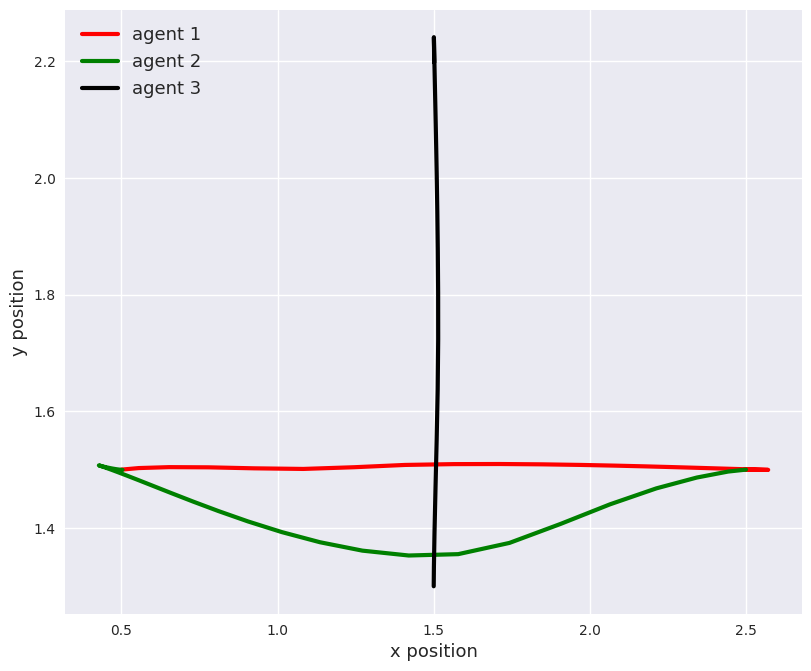

In [111]:
plt.figure(figsize=(9.5,8),dpi=100)
#ax = plt.gca()

# Plot resulting trajecotry of car
plt.plot(x_trj[:,0], x_trj[:,1], '-r',linewidth=3,label='agent 1')
plt.plot(x_trj[:,4], x_trj[:,5], '-g', linewidth=3,label='agent 2')
plt.plot(x_trj[:,8],x_trj[:,9], '-k', linewidth=3,label='agent 3')
#plt.text(-3, 4.2, "Initial positions:$(0.5,3.5);(-3.5,3.5);(4.5,4.5)$", bbox=dict(facecolor='blue', alpha=0.5),fontsize=13)
#plt.arrow(x_trj[:,0][-1], x_trj[:,1][-1],-0.15,0.,shape='full', lw=2,
   #length_includes_head=True, head_width=.05, color='r')

#plt.arrow(x_trj[:,4][-1], x_trj[:,5][-1],0.15,0.,shape='full', lw=2,
   #length_includes_head=True, head_width=.05, color='g')|

#plt.arrow(x_trj[:,8][-1], x_trj[:,9][-1],-0.15,-0.05,shape='full', lw=2,
   #length_includes_head=True, head_width=.05, color='k')


plt.xlabel('x position',fontsize=13)
plt.ylabel('y position',fontsize=13)
#plt.yticks(ticks=np.arange(1.3,1.8,0.02))
plt.legend(loc='upper left',fontsize=13);

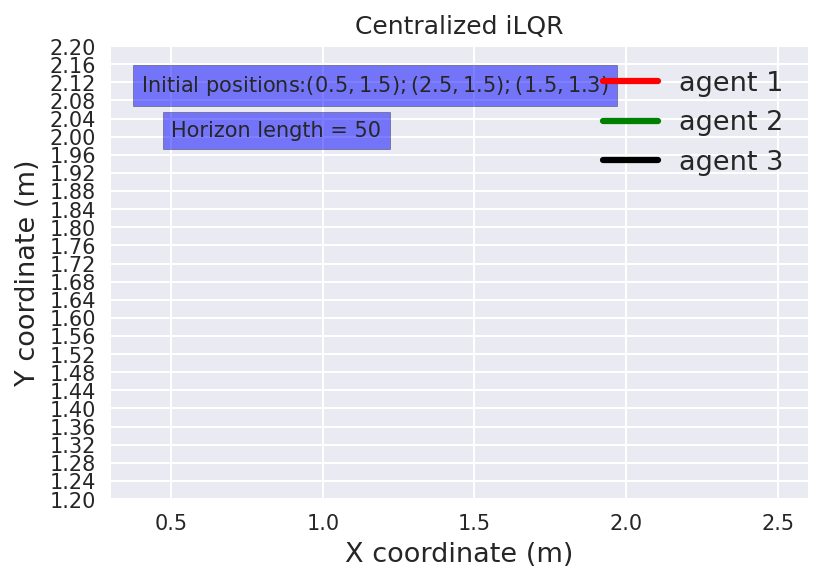

In [114]:
fig = plt.figure(dpi=150)
ax = plt.axes(xlim=(0.3,2.6), ylim=(1.2, 2.2))

ax = plt.gca()

# Plot initial line to fill in as we go
line1, = ax.plot([], [], lw=3,color='r',label='agent 1')
line2, = ax.plot([], [], lw=3,color='g',label='agent 2')
line3, = ax.plot([], [], lw=3,color='k',label='agent 3')
ax.legend(loc='upper right',fontsize=13)
ax.set_xlabel('X coordinate (m)',fontsize=13)
ax.set_ylabel('Y coordinate (m)',fontsize=13)
ax.set_yticks(ticks=np.arange(1.2,2.2,0.04))
ax.text(0.4, 2.1, "Initial positions:$(0.5, 1.5);(2.5, 1.5);(1.5, 1.3)$", bbox=dict(facecolor='blue', alpha=0.5),fontsize=10)
ax.text(0.5,2.0, "Horizon length = 50",bbox=dict(facecolor='blue', alpha=0.5),fontsize=10)
ax.set_title('Centralized iLQR')
def animate(i):
    # Plot resulting trajecotry of car
    
    
    line1.set_xdata(x_trj[:i,0])
    line2.set_xdata(x_trj[:i,4])
    line3.set_xdata(x_trj[:i,8])

    #line.set_ydata(x_trj[:i,1:10:4])
    line1.set_ydata(x_trj[:i,1])
    line2.set_ydata(x_trj[:i,5])
    line3.set_ydata(x_trj[:i,9])

    
    return line1,line2,line3


anim = FuncAnimation(fig, animate, frames=x_trj.shape[0], interval=200) # animation doesn't show up?


In [115]:
anim

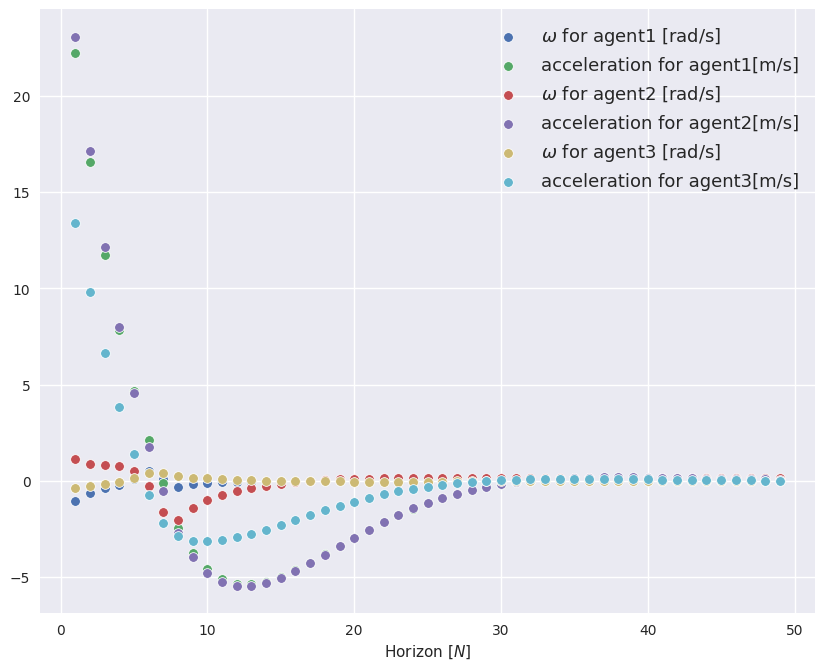

In [116]:
horizon = np.arange(1,N,1)
plt.figure(figsize=(10,8),dpi=100)
sns.scatterplot(x=horizon,y=u_trj[:,0],label='$\omega$ for agent1 [rad/s]');
sns.scatterplot(x=horizon,y=u_trj[:,1],label='acceleration for agent1[m/s]');

sns.scatterplot(x=horizon,y=u_trj[:,2],label='$\omega$ for agent2 [rad/s]');
sns.scatterplot(x=horizon,y=u_trj[:,3],label='acceleration for agent2[m/s]');

sns.scatterplot(x=horizon,y=u_trj[:,4],label='$\omega$ for agent3 [rad/s]');
sns.scatterplot(x=horizon,y=u_trj[:,5],label='acceleration for agent3[m/s]');

plt.legend(fontsize=13);
plt.xlabel('Horizon [$N$]');

### **scenario 2 in the paper (centralized receding-horizon iLQR)**:
#### Agent 1 starts at (0,1.5) and travels to (1.5,2.5), while agent 2 starts at (1.5,1.5) and travels to (0,2.5). Agent 3 is assigned a random position here since the paper only included 2 agents

In [118]:
#Receding horizon iLQR:
N = 15 #prediction horizon at each step
total_horizon = 50 #total horizon for receding-horizon controller
n_states = 4
x0 = np.array([0.5, 1.5, 0, 0,      #1st row for agent1, 2nd row for agent2, 3rd row for agent3
               2.5, 1.5, np.pi ,0 ,  
               1.5, 1.3, np.pi/2 , 0.1 ]) 

# x_ref = np.array([2.5, 1.5, 0 , 0.1 , 0.5, 1.5, np.pi , -0.1 , 1.5, 2.0, np.pi/2, 0.1 ])
x_ref = np.array([2.5, 1.5, 0 , 0 , 0.5, 1.5, np.pi , 0 , 1.5, 2.0, np.pi/2, 0 ])
x_ref_T = x_ref


max_iter  = 15
regu_init = 100
alpha_init = 1

x_trj_opt = np.zeros((total_horizon+1,n_agents*n_states))
x_trj_opt[0,:] = x0
u_trj_opt = []

for m in range(total_horizon):
    
    x_trj, u_trj, _, _, _, _, _ = run_ilqr(x_trj_opt[m,:], N, max_iter, regu_init, alpha_init, x_dim, u_dim, n_agents, x_ref, x_ref_T)
    #each time run_ilqr is called, x_trj and u_trj are returned based on an optiomization over the prediction horizon N
    x_trj_opt[m+1,:] = x_trj[1,:]
    u_trj_opt.append(u_trj[0])

/usr/local/lib/python3.7/dist-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


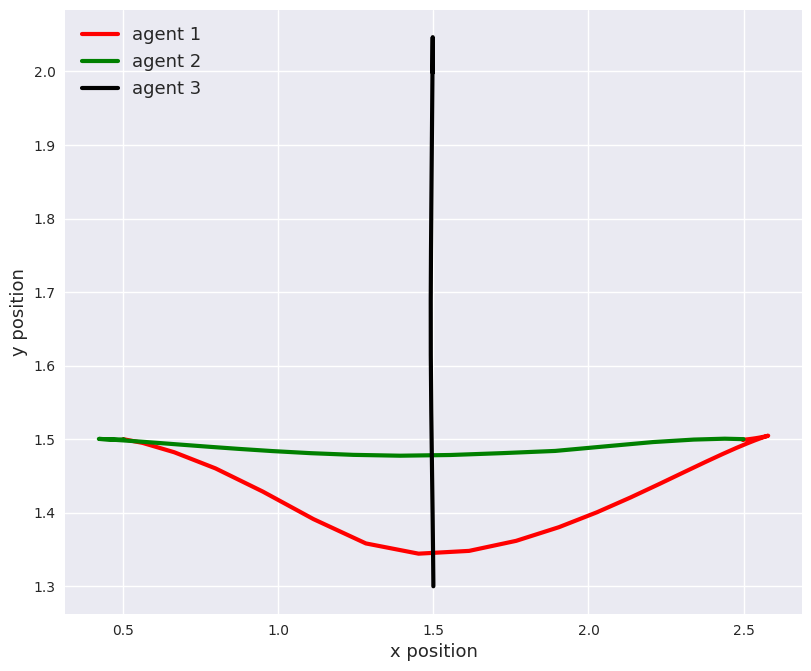

In [119]:
plt.figure(figsize=(9.5,8),dpi=100)
#ax = plt.gca()

# Plot resulting trajecotry of car
plt.plot(x_trj_opt[:,0], x_trj_opt[:,1], '-r',linewidth=3,label='agent 1')
plt.plot(x_trj_opt[:,4], x_trj_opt[:,5], '-g', linewidth=3,label='agent 2')
plt.plot(x_trj_opt[:,8],x_trj_opt[:,9], '-k', linewidth=3,label='agent 3')
#plt.text(-3, 4.2, "Initial positions:$(0.5,3.5);(-3.5,3.5);(4.5,4.5)$", bbox=dict(facecolor='blue', alpha=0.5),fontsize=13)
#plt.arrow(x_trj[:,0][-1], x_trj[:,1][-1],-0.15,0.,shape='full', lw=2,
   #length_includes_head=True, head_width=.05, color='r')

#plt.arrow(x_trj[:,4][-1], x_trj[:,5][-1],0.15,0.,shape='full', lw=2,
   #length_includes_head=True, head_width=.05, color='g')|

#plt.arrow(x_trj[:,8][-1], x_trj[:,9][-1],-0.15,-0.05,shape='full', lw=2,
   #length_includes_head=True, head_width=.05, color='k')


plt.xlabel('x position',fontsize=13)
plt.ylabel('y position',fontsize=13)
#plt.yticks(ticks=np.arange(1.3,1.8,0.02))
plt.legend(loc='upper left',fontsize=13);

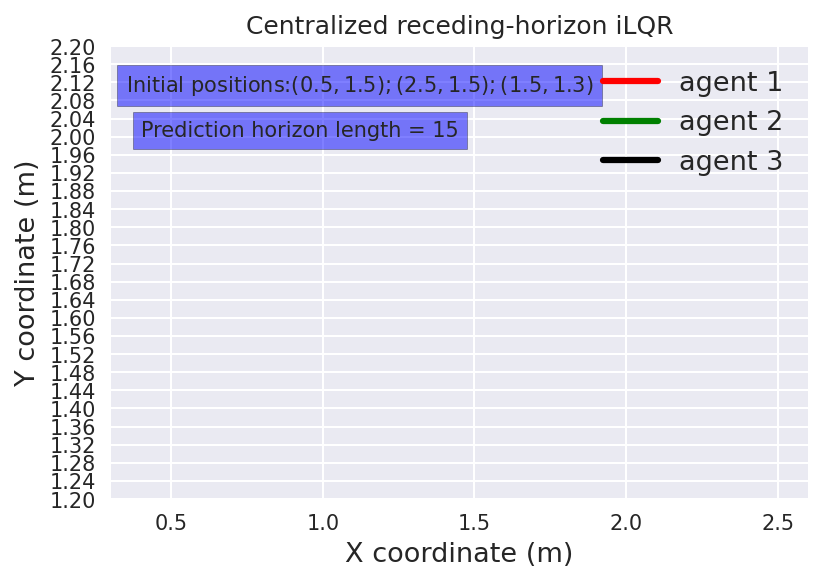

In [132]:
fig = plt.figure(dpi=150)
ax = plt.axes(xlim=(0.3,2.6), ylim=(1.2, 2.2))

ax = plt.gca()

# Plot initial line to fill in as we go
line1, = ax.plot([], [], lw=3,color='r',label='agent 1')
line2, = ax.plot([], [], lw=3,color='g',label='agent 2')
line3, = ax.plot([], [], lw=3,color='k',label='agent 3')
ax.legend(loc='upper right',fontsize=13)
ax.set_xlabel('X coordinate (m)',fontsize=13)
ax.set_ylabel('Y coordinate (m)',fontsize=13)
ax.set_yticks(ticks=np.arange(1.2,2.2,0.04))
ax.text(0.35, 2.1, "Initial positions:$(0.5, 1.5);(2.5, 1.5);(1.5, 1.3)$", bbox=dict(facecolor='blue', alpha=0.5),fontsize=10)
ax.text(0.4,2.0, "Prediction horizon length = 15",bbox=dict(facecolor='blue', alpha=0.5),fontsize=10)
ax.set_title('Centralized receding-horizon iLQR')
def animate(i):
    # Plot resulting trajecotry of car
    
    
    line1.set_xdata(x_trj_opt[:i,0])
    line2.set_xdata(x_trj_opt[:i,4])
    line3.set_xdata(x_trj_opt[:i,8])

    #line.set_ydata(x_trj[:i,1:10:4])
    line1.set_ydata(x_trj_opt[:i,1])
    line2.set_ydata(x_trj_opt[:i,5])
    line3.set_ydata(x_trj_opt[:i,9])

    
    return line1,line2,line3


anim = FuncAnimation(fig, animate, frames=x_trj_opt.shape[0], interval=200) 

In [133]:
anim

### Decentralized receding-horizon iLQR:

In [33]:
def x_dim_generate(problems,n_states): 
    
    x_dim_list = []
 
    for i in list(problems.values()):

        x_dim_list.append([n_states]*len(i))
    
    
    assert(len(x_dim_list)) == len(problems)
    
        
    return x_dim_list

In [34]:
def u_dim_generate(problems,n_inputs):
    
    u_dim_list = []
    
    for i in list(problems.values()):

        u_dim_list.append([n_inputs]*len(i))
    
    assert(len(u_dim_list)) == len(problems)
    
    return u_dim_list

In [35]:
def online_split_states(n_agents,n_states,N,problems,X):
    # problems is a list of indices grouped together for each set of agents
    #i.e., problems = [
#     (1,),
#     (2, 0)
#                    ]
    x_dims = [n_states]*n_agents
#     X = np.tile(np.arange(n_agents * n_states), (N, 1))
    full_states = [np.zeros((N,0))] * len(problems)
    for i, problem in enumerate(problems):
        for id_ in problem:
            full_states[i] = np.concatenate([
                full_states[i], X[:,id_*n_states:(id_+1)*n_states]
            ], axis=1)
        
    return full_states


def online_split_inputs(n_agents,n_inputs,N,problems,U):

    u_dims = [n_inputs]*n_agents
#         U = np.tile(np.arange(n_agents * n_inputs), (N, 1))
    full_inputs = [np.zeros((N,0))] * len(problems)
    for i, problem in enumerate(problems):
        for id_ in problem:
            full_inputs[i] = np.concatenate([
                full_inputs[i], U[:,id_*n_inputs:(id_+1)*n_inputs]
            ], axis=1)

    return full_inputs


In [36]:
def define_inter_graph_threshold(X, n_agents, radius, x_dims):
    """Compute the interaction graph based on a simple thresholded distance
    for each pair of agents sampled over the trajectory
    """
    planning_radii = 4 * radius
    rel_dists = compute_pairwise_distance(X, x_dims).T

    N = X.shape[0]
    # n_samples = 10 
    # sample_step = max(N // n_samples, 1)
    sample_step = 1
    sample_slice = slice(0, N + 1, sample_step)
    
    # Put each pair of agents within each others' graphs if they are within
    # some threshold distance from each other.
    graph = {i: [i] for i in range(n_agents)}
    pair_inds = np.array(list(itertools.combinations(range(n_agents), 2)))
    for i, pair in enumerate(pair_inds):
        if np.any(rel_dists[sample_slice, i] < planning_radii):
            graph[pair[0]].append(pair[1])
            graph[pair[1]].append(pair[0])
    
    graph = {agent_id: sorted(prob_ids) for agent_id, prob_ids in graph.items()}
    
    return graph

In [47]:
# Define parameters:
n_agents = 3
n_states = 4
n_inputs = 2
x_dim = [n_states]*n_agents
u_dim = [n_inputs]*n_agents


N = 15 #prediction horizon
total_horizon = 50 #total horizon

#initial condition
x0 = np.array([0.5, 1.5, 0, 0,      #1st row for agent1, 2nd row for agent2, 3rd row for agent3
               2.5, 1.5, np.pi ,0 ,  
               1.5, 1.3, np.pi/2 , 0.1 ]) 

# x_ref = np.array([2.5, 1.5, 0 , 0.1 , 0.5, 1.5, np.pi , -0.1 , 1.5, 2.0, np.pi/2, 0.1 ])
x_ref = np.array([2.5, 1.5, 0 , 0 , 0.5, 1.5, np.pi , 0 , 1.5, 2.0, np.pi/2, 0 ])
x_ref_T = x_ref


max_iter  = 15
regu_init = 100
alpha_init = 1
group_radius = 0.25

x_trj_opt = np.zeros((total_horizon+1,n_agents*n_states))
x_trj_opt[0,:] = x0
u_trj_opt = np.zeros((total_horizon+1,n_agents*n_inputs))

In [48]:
import time
from multiprocessing import Pool
import multiprocessing

In [49]:
# main loop:
for m in range(total_horizon):

    problems = define_inter_graph_threshold(x_trj_opt, n_agents, group_radius, x_dim)
                
    x_trj_split = online_split_states(n_agents,n_states,total_horizon+1,list(problems.values()),x_trj_opt)
    
    u_trj_split = online_split_inputs(n_agents,n_inputs,total_horizon+1,list(problems.values()),u_trj_opt)
    
    x_ref_split = online_split_states(n_agents,n_states,1,list(problems.values()),x_ref.reshape(1,-1))
    #x_ref should also be split up
    
    x_dim_list = x_dim_generate(problems,n_states) 
    u_dim_list = u_dim_generate(problems,n_inputs)
    

    for x_trj_i, (agent_id,ids) in zip(x_trj_split, problems.items()): #include problems
    #how to make it parallel using multiprocessing?

        #overriding x_dim,u_dim depending on the 'decentralization grouping'
        x_dim_change = x_dim_list[agent_id] 
        u_dim_change = u_dim_list[agent_id]
        
        #overidding `n_agents`
        x_ref_problem = x_ref_split[agent_id].flatten()
        n_agents_change = int((x_ref_problem.shape[0])/n_states)
        
        #using multiprocessing?:
 
        x_trj, u_trj, cost_trace, regu_trace, redu_ratio_trace, redu_trace, alpha_trace = run_ilqr(x_trj_i[m,:], N, max_iter, regu_init, alpha_init, x_dim_change, u_dim_change, n_agents_change, x_ref_problem, x_ref_problem)
        
        #each x_trj has N rows, and the No. of columns is determined by how many agents there are in each optimization problem
        
        col_ind = ids.index(agent_id)
        
        x_trj_opt[m+1,agent_id*n_states:(agent_id+1)*n_states] = x_trj[1,col_ind*n_states:(col_ind+1)*n_states]
        u_trj_opt[m,agent_id*n_inputs:(agent_id+1)*n_inputs] = u_trj[0,col_ind*n_inputs:(col_ind+1)*n_inputs]
        
        # for example, at each time step we have 3 problems to solve, and 2 agents are grouped together while the 3rd agent is isolated;
        # then, problems = [(8,),(8,),(4,)], since each agent has 4 states, and x_trj[1,:] has shape 
        #[(N,8),(N,8),(N,4)], for each x_trj_i in x_trj_split
        
        
    # How to update x_trj_opt for each `m` in total_horizon? 
    # for example, if `x_trj_i` obtained in the nested loop above has shape (N,8),(N,8),(N,4) respectively, 
    # then how should I obtain the new `x_trj_opt`? I think x_trj_opt should always have `n_agents*n_states` columns such that a 
    # new decentralization graph is being generated at each `m` in `total_horizon`
  

In [45]:
# Running with multiprocess pool:


for m in range(total_horizon):

  problems = define_inter_graph_threshold(x_trj_opt, n_agents, group_radius, x_dim)
              
  x_trj_split = online_split_states(n_agents,n_states,total_horizon+1,list(problems.values()),x_trj_opt)
  
  u_trj_split = online_split_inputs(n_agents,n_inputs,total_horizon+1,list(problems.values()),u_trj_opt)
  
  x_ref_split = online_split_states(n_agents,n_states,1,list(problems.values()),x_ref.reshape(1,-1))
  #x_ref should also be split up
  
  x_dim_list = x_dim_generate(problems,n_states) 
  u_dim_list = u_dim_generate(problems,n_inputs)
  
  # for x_trj_i, (agent_id,ids) in zip(x_trj_split, problems.items()): #include problems
  # #how to make it parallel using multiprocessing?

  #     #overriding x_dim,u_dim depending on the 'decentralization grouping'
  #   x_dim_change = x_dim_list[agent_id] 
  #   u_dim_change = u_dim_list[agent_id]
    
  #   #overidding `n_agents`
  #   x_ref_problem = x_ref_split[agent_id].flatten()
  #   n_agents_change = int((x_ref_problem.shape[0])/n_states)


  # if __name__ == "__main__":
  with Pool(multiprocessing.cpu_count()-1) as p:
    result_list = p.starmap(run_ilqr,[[x_trj_i[m,:], N, max_iter, regu_init, alpha_init, \
                          x_dim_list[agent_id],u_dim_list[agent_id],int(x_ref_split[agent_id].flatten().shape[0]/n_states), \
                          x_ref_split[agent_id].flatten(),x_ref_split[agent_id].flatten()] for x_trj_i,(agent_id,ids) in zip(x_trj_split,problems.items())])
    
    # col_ind = ids.index(agent_id)
    
        
    # x_trj_opt[m+1,agent_id*n_states:(agent_id+1)*n_states] = x_trj[1,col_ind*n_states:(col_ind+1)*n_states]
    
    # x_trj_opt[m+1,agent_id*n_states:(agent_id+1)*n_states] = result_list[m][0][1,col_ind*n_states:(col_ind+1)*n_states]

    # u_trj_opt[m,agent_id*n_inputs:(agent_id+1)*n_inputs] = u_trj[0,col_ind*n_inputs:(col_ind+1)*n_inputs]
    
    # u_trj_opt[m,agent_id*n_inputs:(agent_id+1)*n_inputs] = result_list[m][1][0,col_ind*n_inputs:(col_ind+1)*n_inputs]



/usr/local/lib/python3.7/dist-packages/autograd/numpy/linalg.py:100: RuntimeWarning: divide by zero encountered in true_divide
  return expand(g / ans) * x
/usr/local/lib/python3.7/dist-packages/autograd/numpy/linalg.py:100: RuntimeWarning: invalid value encountered in multiply
  return expand(g / ans) * x
/usr/local/lib/python3.7/dist-packages/autograd/tracer.py:48: RuntimeWarning: divide by zero encountered in true_divide
  return f_raw(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in multiply
  return f_raw(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/autograd/numpy/numpy_vjps.py:35: RuntimeWarning: invalid value encountered in multiply
  lambda ans, x, y : unbroadcast_f(y, lambda g: x * g))
/usr/local/lib/python3.7/dist-packages/autograd/numpy/numpy_vjps.py:52: RuntimeWarning: invalid value encountered in true_divide
  defvjp(anp.true_divide, lambda ans, x, y : unbroadcast_f(x, lambda g: g / y),
/

KeyboardInterrupt: ignored

Text(0.5, 1.0, 'Decentralized iLQR')

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


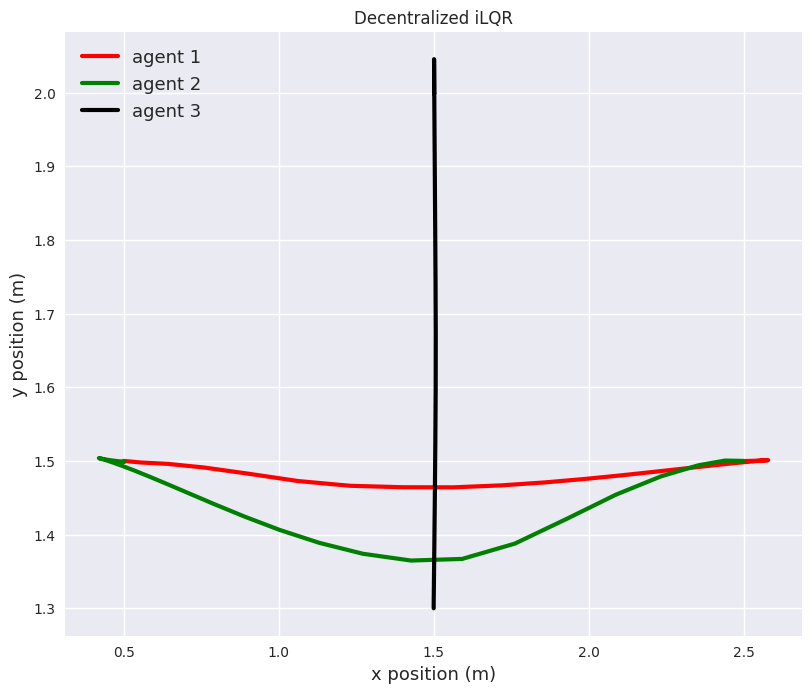

In [50]:
plt.figure(figsize=(9.5,8),dpi=100)
#ax = plt.gca()

# Plot resulting trajecotry of car
plt.plot(x_trj_opt[:,0], x_trj_opt[:,1], '-r',linewidth=3,label='agent 1')
plt.plot(x_trj_opt[:,4], x_trj_opt[:,5], '-g', linewidth=3,label='agent 2')
plt.plot(x_trj_opt[:,8],x_trj_opt[:,9], '-k', linewidth=3,label='agent 3')
#plt.text(-3, 4.2, "Initial positions:$(0.5,3.5);(-3.5,3.5);(4.5,4.5)$", bbox=dict(facecolor='blue', alpha=0.5),fontsize=13)
#plt.arrow(x_trj[:,0][-1], x_trj[:,1][-1],-0.15,0.,shape='full', lw=2,
   #length_includes_head=True, head_width=.05, color='r')

#plt.arrow(x_trj[:,4][-1], x_trj[:,5][-1],0.15,0.,shape='full', lw=2,
   #length_includes_head=True, head_width=.05, color='g')|

#plt.arrow(x_trj[:,8][-1], x_trj[:,9][-1],-0.15,-0.05,shape='full', lw=2,
   #length_includes_head=True, head_width=.05, color='k')


plt.xlabel('x position (m)',fontsize=13)
plt.ylabel('y position (m)',fontsize=13)
#plt.yticks(ticks=np.arange(1.3,1.8,0.02))
plt.legend(loc='upper left',fontsize=13);
plt.title('Decentralized iLQR')

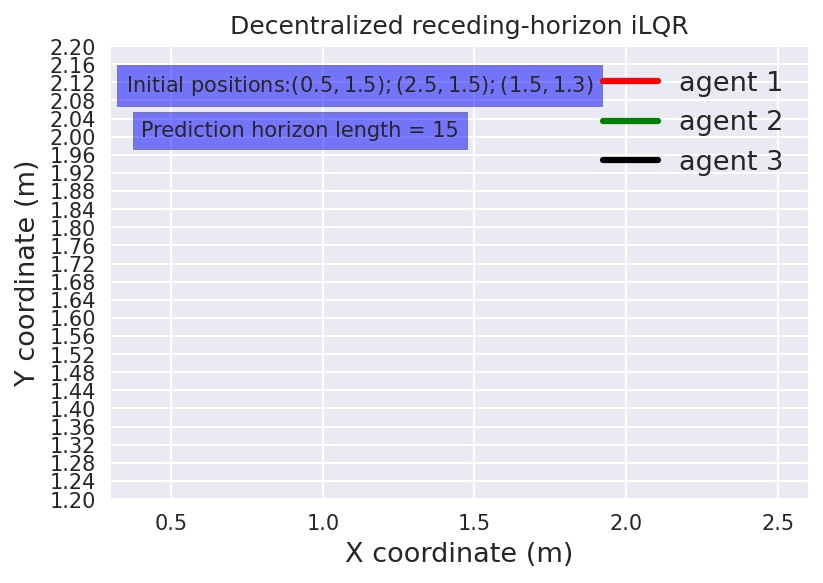

In [62]:
fig = plt.figure(dpi=150)
ax = plt.axes(xlim=(0.3,2.6), ylim=(1.2, 2.2))

ax = plt.gca()

# Plot initial line to fill in as we go
line1, = ax.plot([], [], lw=3,color='r',label='agent 1')
line2, = ax.plot([], [], lw=3,color='g',label='agent 2')
line3, = ax.plot([], [], lw=3,color='k',label='agent 3')
ax.legend(loc='upper right',fontsize=13)
ax.set_xlabel('X coordinate (m)',fontsize=13)
ax.set_ylabel('Y coordinate (m)',fontsize=13)
ax.set_yticks(ticks=np.arange(1.2,2.2,0.04))
ax.text(0.35, 2.1, "Initial positions:$(0.5, 1.5);(2.5, 1.5);(1.5, 1.3)$", bbox=dict(facecolor='blue', alpha=0.5),fontsize=10)
ax.text(0.4,2.0, "Prediction horizon length = 15",bbox=dict(facecolor='blue', alpha=0.5),fontsize=10)
ax.set_title('Decentralized receding-horizon iLQR')
def animate(i):
    # Plot resulting trajecotry of car
    
    
    line1.set_xdata(x_trj_opt[:i,0])
    line2.set_xdata(x_trj_opt[:i,4])
    line3.set_xdata(x_trj_opt[:i,8])

    #line.set_ydata(x_trj[:i,1:10:4])
    line1.set_ydata(x_trj_opt[:i,1])
    line2.set_ydata(x_trj_opt[:i,5])
    line3.set_ydata(x_trj_opt[:i,9])

    
    return line1,line2,line3


anim = FuncAnimation(fig, animate, frames=x_trj_opt.shape[0], interval=200) 

In [63]:
anim